In [1]:
import math
import torch
from diffusion_edf.dist import sample_igso3

from matplotlib import pyplot as plt

import numpy as np
np.set_printoptions(precision=4, floatmode="fixed")

In [2]:
sample_w_max = sample_igso3(eps=100., N=100000)
sample_w_max = torch.acos(sample_w_max[:,0])*2
sample_w_degree_max = sample_w_max / torch.pi * 180.

$IG_{SO(3)}$ almost converges at $t=6$

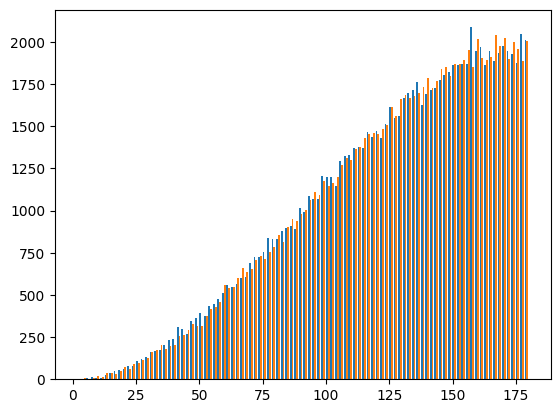

In [3]:
t = 6.
eps = t/2

sample = sample_igso3(eps=eps, N=100000)
sample_w = torch.acos(sample[:,0])*2
sample_w_degree = sample_w / torch.pi * 180.

plt.hist([sample_w_degree, sample_w_degree_max], bins=100)
plt.show()

$\textrm{rotation angle}\ \  w\approx \sqrt{t}\times 38.5\degree$

In [4]:
for t in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    eps = t/2

    sample = sample_igso3(eps=eps, N=100000)
    sample_w = torch.acos(sample[:,0])*2
    sample_w_degree = sample_w / torch.pi * 180.
    print(sample_w.std().item() / math.sqrt(t))
print(f"\n degree: {sample_w_degree.std().item() / math.sqrt(t)}")

0.6739040003128427
0.6734584355551636
0.6760268252249253
0.6744271657572246
0.6710079354754728

 degree: 38.44592272253122


# Play

tensor(3.8429, dtype=torch.float64)


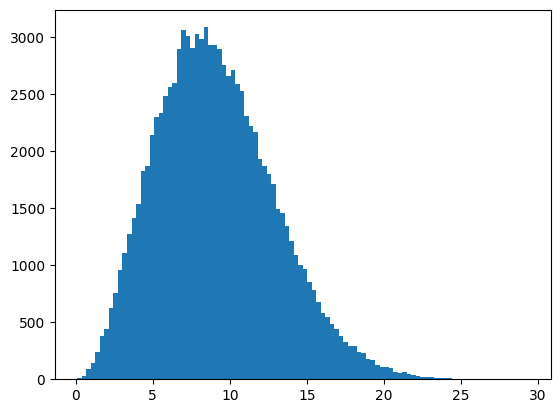

In [5]:
t = 1e-2
eps = t/2

sample = sample_igso3(eps=eps, N=100000)
sample_w = torch.acos(sample[:,0])*2
sample_w_degree = sample_w / torch.pi * 180.
print(sample_w_degree.std())

plt.hist(sample_w_degree, bins=100)
plt.show()

# Calculator

In [6]:
def std_calculator(t_schedule, lin_mult, ang_mult = 1., p = 0.95, N = 100000):
    lin_stds = []
    ang_stds = []
    lin_maxs = []
    ang_maxs = []
    lin_meds = []
    ang_meds = []
    lin_mods = []
    ang_mods = []

    for t in t_schedule:
        eps = t/2 * (ang_mult**2)
        std = torch.tensor([math.sqrt(t*3)]) * lin_mult
        lin_stds.append(std)
        lin_samples = torch.randn(N,3).norm(dim=-1) * std

        sample = sample_igso3(eps=eps, N=N)
        sample_w = torch.acos(sample[:,0])*2
        sample_w_degree = sample_w / torch.pi * 180.
        ang_stds.append(sample_w_degree.std().unsqueeze(0))
        ang_max = sample_w_degree.sort().values[int(p*N)]
        ang_maxs.append(ang_max.unsqueeze(0))
        lin_max = lin_samples.sort().values[int(p*N)]
        lin_maxs.append(lin_max.unsqueeze(0))

        lin_meds.append(lin_samples.median().unsqueeze(0))
        ang_meds.append(sample_w_degree.median().unsqueeze(0))

        boundaries = torch.linspace(0., ang_max*1.2, steps=100)
        bins = torch.bucketize(sample_w_degree, boundaries=boundaries)
        ang_mod = boundaries[bins.mode().values]

        boundaries = torch.linspace(0., lin_max*1.2, steps=100)
        bins = torch.bucketize(lin_samples, boundaries=boundaries)
        lin_mod = boundaries[bins.mode().values]

        lin_mods.append(lin_mod.unsqueeze(0))
        ang_mods.append(ang_mod.unsqueeze(0))

    return torch.cat(lin_stds), torch.cat(ang_stds), torch.cat(lin_maxs), torch.cat(ang_maxs), torch.cat(lin_meds), torch.cat(ang_meds), torch.cat(lin_mods), torch.cat(ang_mods)

In [7]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([1e-4, 1e-3, 1e-2, 1e-1, 1.], ang_mult = 2.5, lin_mult=20., p=0.95)

print(f"angular std: {ang_stds.numpy()}")
print(f"angular median: {ang_meds.numpy()}")
print(f"angular mode: {ang_mods.numpy()}")
print(f"angular max: {ang_maxs.numpy()}")
print("========================================")
print(f"linear std: {lin_stds.numpy()}")
print(f"linear median: {lin_meds.numpy()}")
print(f"linear mode: {lin_mods.numpy()}")
print(f"linear max: {lin_maxs.numpy()}")

angular std: [ 0.9635  3.0592  9.5985 29.5899 37.0661]
angular median: [  2.2011   6.9414  21.9962  67.6951 131.9860]
angular mode: [  2.0345   6.4319  19.3432  65.5844 170.1440]
angular max: [  3.9963  12.6341  39.8954 122.9707 175.4610]
linear std: [ 0.3464  1.0954  3.4641 10.9545 34.6410]
linear median: [ 0.5326  1.6838  5.3170 16.8148 53.1160]
linear mode: [ 0.4697  1.3724  4.8230 16.7062 51.5304]
linear max: [ 0.9688  3.0600  9.7047 30.6281 96.6196]


In [8]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([1e-4, 1e-3, 5e-3, 3e-2, 1e-1, 1.], ang_mult = 2.5, lin_mult=20., p=0.95)

print(f"angular std: {ang_stds.numpy()}")
print(f"angular median: {ang_meds.numpy()}")
print(f"angular mode: {ang_mods.numpy()}")
print(f"angular max: {ang_maxs.numpy()}")
print("========================================")
print(f"linear std: {lin_stds.numpy()}")
print(f"linear median: {lin_meds.numpy()}")
print(f"linear mode: {lin_mods.numpy()}")
print(f"linear max: {lin_maxs.numpy()}")

angular std: [ 0.9646  3.0551  6.8456 16.6163 29.5473 37.1669]
angular median: [  2.1968   6.9628  15.5402  37.7840  67.6796 132.2153]
angular mode: [  1.9885   6.2826  14.0822  35.8662  66.9212 178.7964]
angular max: [  4.0012  12.6418  28.3361  68.8131 122.6889 175.6036]
linear std: [ 0.3464  1.0954  2.4495  6.0000 10.9545 34.6410]
linear median: [ 0.5324  1.6808  3.7743  9.2286 16.7787 53.2537]
linear mode: [ 0.4933  1.4798  3.2376  8.5615 15.5921 48.0410]
linear max: [ 0.9690  3.0521  6.8488 16.8172 30.6273 96.6680]
